In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
from astropy.coordinates import SkyCoord

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch

# Astropy
from astropy.timeseries import LombScargle

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.4.4


# Load Catalog Data from Vizier

In [5]:
## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

In [ ]:
# let's query data from Anders StarHorse EDR3
CATALOGUE = "I/354"

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

# Fetch tables
tables = voresource.get_tables()

# We can also extract the tables names for later use
tables_names = list(tables.keys())
table_full_name = "I/354/starhorse2021"

# Initialize tap service
tap_service = voresource.get_service("tap")
# Run a query to get the first 2000000 rows given a sky constraint (40x40 deg)
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
                            FROM "{table_full_name}" WHERE (DE_ICRS BETWEEN 0 and 40) AND (RA_ICRS BETWEEN 80 and 120)')


In [ ]:
# Obtain table from TAP query
table0 = tap_records.to_table()

# Convert to pandas dataframe
table_df = table0.to_pandas()

print (f"Number of objects: {len(table_df)}")

Number of objects: 2000000


In [ ]:
# store to location where we have space.../nvme/users/atzanida/tmp/starhorse_query.parquet
#table_df.to_parquet('/nvme/users/atzanida/tmp/starhorse_query.parquet')

In [2]:
# load table_df from epyc
table_df = pd.read_parquet('/nvme/users/atzanida/tmp/starhorse_query.parquet')

83.31175218815 22.1935072393


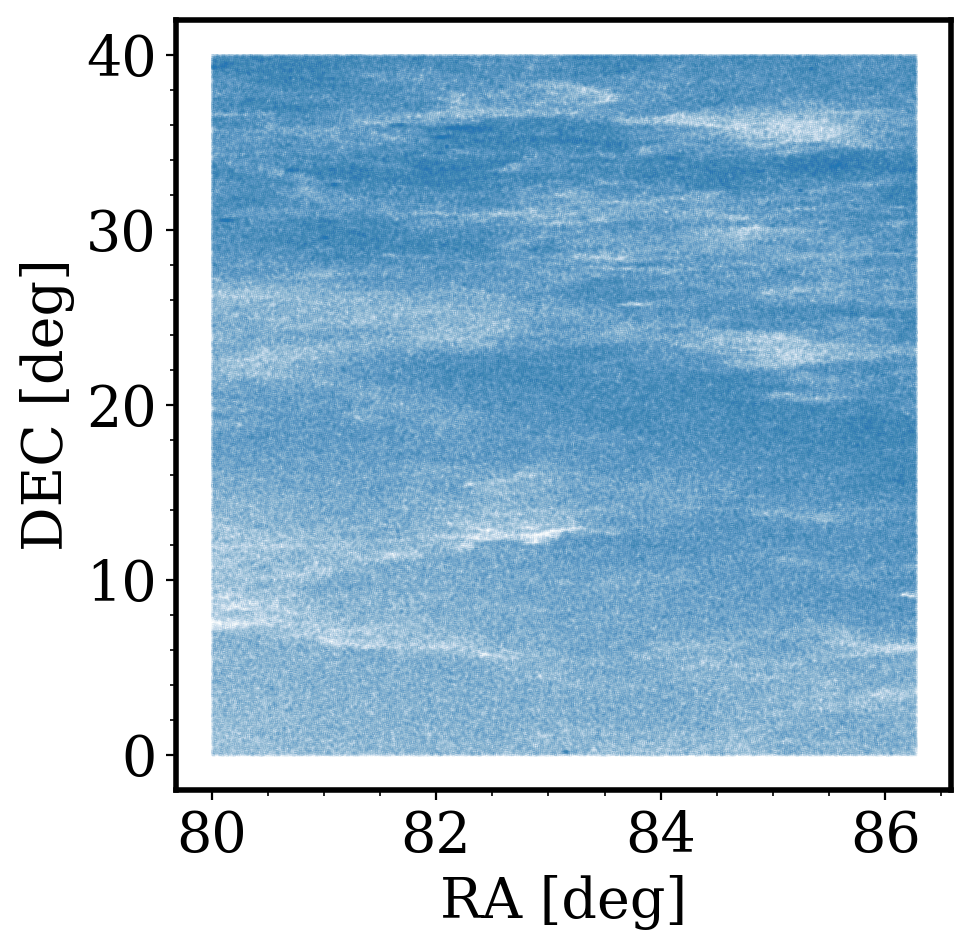

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(table_df['RA_ICRS'], table_df['DE_ICRS'], s=0.0001)
print (np.median(table_df['RA_ICRS']), np.median(table_df['DE_ICRS']))

plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.minorticks_on()

In [4]:
# select only relevant columns
my_col = ['Source', 'RA_ICRS', 'DE_ICRS', 'teff50', 'logg50', 'GMAG0', 'BP-RP0', 'dist50']
table_update = table_df[my_col]

In [5]:
table_update.head(5)

,Source,RA_ICRS,DE_ICRS,teff50,logg50,GMAG0,BP-RP0,dist50
0,187905712555968256,80.000005,39.058052,4563.56,4.616425,6.717016,1.374512,0.898541
1,3421170836878697600,80.000006,26.854739,7374.55,4.202878,2.577847,0.401294,3.914362
2,3387603708955349760,80.000008,12.136546,5920.65,4.297088,4.080964,0.752764,1.476843
3,3394465215564300672,80.000013,17.138910,6385.10,3.996000,2.853344,0.620375,0.269334
4,3421599027937225216,80.000014,28.333220,5975.03,4.427459,4.746234,0.717740,1.368634


## Initialize Dask Client

In [5]:
# initialize dask worker... 
from dask.distributed import Client
client = Client(n_workers=6, memory_limit="20GiB", threads_per_worker=1)

In [10]:
from hats_import.catalog.arguments import ImportArguments
from hats_import.pipeline import pipeline_with_client

In [17]:
args = ImportArguments(
    ra_column="RA_ICRS",
    dec_column="DE_ICRS",
    lowest_healpix_order=2,
    highest_healpix_order=7,
    file_reader="parquet",
    input_file_list=["/nvme/users/atzanida/tmp/starhorse_query.parquet"],
    output_artifact_name="from_import_pipeline",
    output_path="/nvme/users/atzanida/tmp/",
    resume=False,
)

In [18]:
with Client(n_workers=4) as client:
    pipeline_with_client(args, client)

Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/1 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/1 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/5 [00:00<?, ?it/s]

Finishing :   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
!ls /nvme/users/atzanida/tmp/

NEW_output_zubercal_dipper_search_smallv2_trial.parquet
StarHorseApri21_hips
StarHorseApri21_hips_new
StarHorseApril21_output_hips
StarHorse_Dec9070_lc_compute_v1.parquet
StarHorse_Dec9080.parquet
batch_aug24
batch_aug29
batch_oct14
batch_oct22
batch_oct31
dask-scratch-space
data_files
fg_full_feb16.parquet
from_import_pipeline
new_batch
output_zubercal_dipper_search_smallv1.parquet
output_zubercal_dipper_search_smallv1_trial.parquet
output_zubercal_dipper_search_smallv2_trial.parquet
psfcat_ztf
sample_final_starhorse_hips
starH24
starhorse_hips
starhorse_new_april21.parquet
starhorse_query.parquet
ztf_periodic.ascii


In [6]:
# load my default table
from_dataframe_catalog = lsdb.read_hats("/nvme/users/atzanida/tmp/from_import_pipeline")

In [7]:
from_dataframe_catalog

,Source,RA_ICRS,DE_ICRS,mass16,mass50,mass84,teff16,teff50,teff84,logg16,logg50,logg84,met16,met50,met84,dist05,dist16,dist50,dist84,dist95,AV05,AV16,AV50,AV84,AV95,fidelity,XGal,YGal,ZGal,RGal,FlagPhoto,FlagOut,BP/RPCorr,AG50,ABP50,ARP50,GMAG0,BP-RP0,Norder,Dir,Npix
npartitions=5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 2, Pixel: 5",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 2, Pixel: 89",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 92",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 94",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 95",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 6,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43870,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:44381,Total threads: 1
Dashboard: http://127.0.0.1:42443/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:37030,


In [23]:
client = Client(n_workers=6, memory_limit="10GiB", threads_per_worker=1)

In [8]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 6,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42663,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:39593,Total threads: 1
Dashboard: http://127.0.0.1:38926/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:41497,


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - from_import_pipeline'}>)

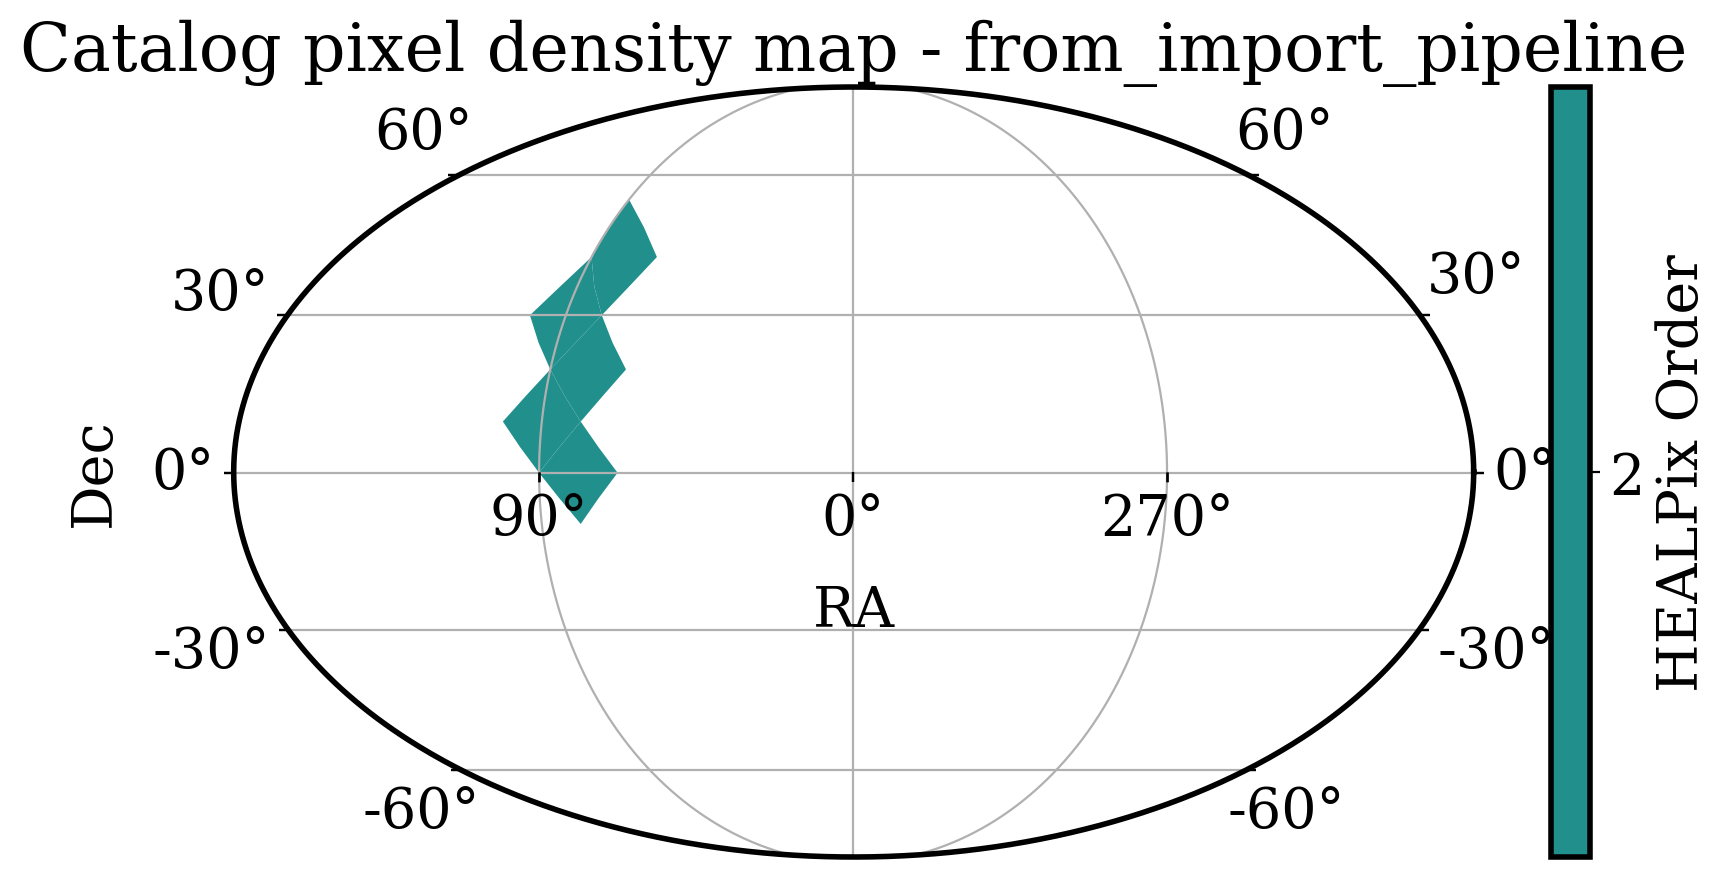

In [9]:
from_dataframe_catalog.plot_pixels()

In [10]:
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch

In [11]:
catalogs_dir = "https://data.lsdb.io/hats"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf/ztf_dr14/"
ztf_source_path = f"{catalogs_dir}/ztf/ztf_zource/"
ztf_object_margin_path = f"{catalogs_dir}/ztf/ztf_dr14_10arcs"

# Define a 1 degree cone region of interest
ra_field, dec_field = 83.31175218815, 22.1935072393
cone_search = ConeSearch(ra=ra_field, dec=dec_field, radius_arcsec=1_000)

# Load ZTF object table
ztf = lsdb.read_hats("https://data.lsdb.io/hats/ztf_dr14/ztf_object/", columns=['ra', 'dec', 'ps1_objid'], search_filter=cone_search)

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hats("https://data.lsdb.io/hats/ztf_dr14/ztf_source/", columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], search_filter=cone_search)

In [ ]:
# we want to make some selection queries to the HATS starhorse table

In [12]:
query = (from_dataframe_catalog['teff50']>5_000) &\
         (from_dataframe_catalog['teff50']<7_000) &\
          (from_dataframe_catalog['logg50']>3.0) &\
              (from_dataframe_catalog['logg50']<4.5)

In [13]:
focus_table = from_dataframe_catalog[query]

In [14]:
focus_table

,Source,RA_ICRS,DE_ICRS,mass16,mass50,mass84,teff16,teff50,teff84,logg16,logg50,logg84,met16,met50,met84,dist05,dist16,dist50,dist84,dist95,AV05,AV16,AV50,AV84,AV95,fidelity,XGal,YGal,ZGal,RGal,FlagPhoto,FlagOut,BP/RPCorr,AG50,ABP50,ARP50,GMAG0,BP-RP0,Norder,Dir,Npix
npartitions=5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 2, Pixel: 5",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 2, Pixel: 89",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 92",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 94",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 2, Pixel: 95",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
_sample = ztf.crossmatch(focus_table, radius_arcsec=1)

/epyc/users/atzanida/anaconda3/envs/lsdb_env_25A/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [16]:
_sources = _sample.join_nested(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid", nested_column_name="sources")

_sources = _sources._ddf # remove once have added LSDB wrappers for nested_dask

/epyc/users/atzanida/anaconda3/envs/lsdb_env_25A/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [16]:
_sources

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,Source_from_import_pipeline,RA_ICRS_from_import_pipeline,DE_ICRS_from_import_pipeline,mass16_from_import_pipeline,mass50_from_import_pipeline,mass84_from_import_pipeline,teff16_from_import_pipeline,teff50_from_import_pipeline,teff84_from_import_pipeline,logg16_from_import_pipeline,logg50_from_import_pipeline,logg84_from_import_pipeline,met16_from_import_pipeline,met50_from_import_pipeline,met84_from_import_pipeline,dist05_from_import_pipeline,dist16_from_import_pipeline,dist50_from_import_pipeline,dist84_from_import_pipeline,dist95_from_import_pipeline,AV05_from_import_pipeline,AV16_from_import_pipeline,AV50_from_import_pipeline,AV84_from_import_pipeline,AV95_from_import_pipeline,fidelity_from_import_pipeline,XGal_from_import_pipeline,YGal_from_import_pipeline,ZGal_from_import_pipeline,RGal_from_import_pipeline,FlagPhoto_from_import_pipeline,FlagOut_from_import_pipeline,BP/RPCorr_from_import_pipeline,AG50_from_import_pipeline,ABP50_from_import_pipeline,ARP50_from_import_pipeline,GMAG0_from_import_pipeline,BP-RP0_from_import_pipeline,Norder_from_import_pipeline,Dir_from_import_pipeline,Npix_from_import_pipeline,_dist_arcsec,sources
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1701868077936803840,double[pyarrow],double[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
1702008815425159168,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702079184169336832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [33]:
obj_1 = _sources.head(1)

Text(0.5, 0, 'Time [MJD]')

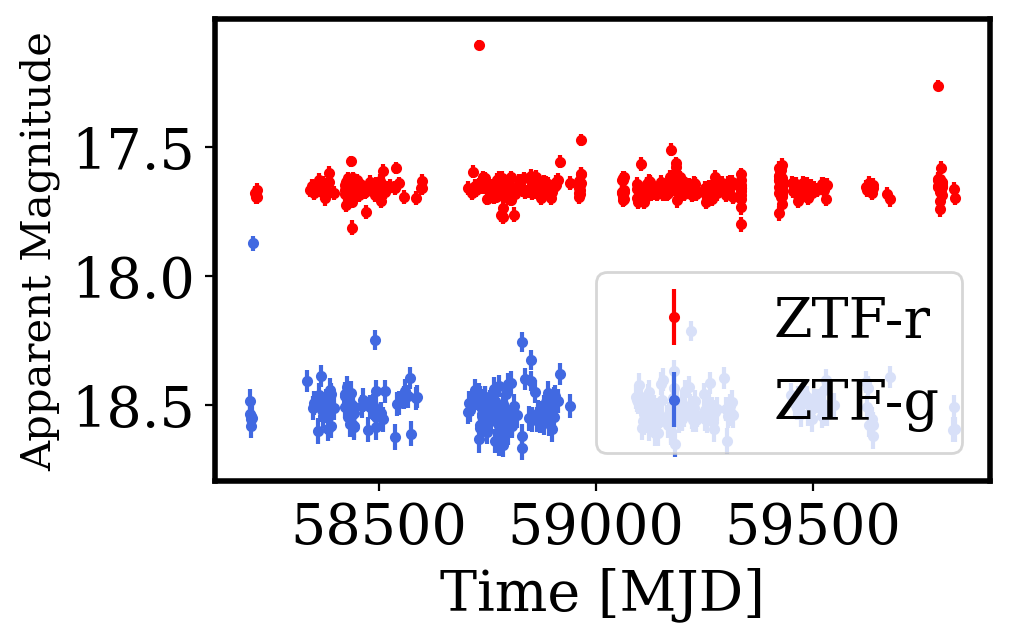

In [56]:
lc = obj_1.sources.array[0]
# plot multiband light cureve band==r band ==g with red and green
plt.figure(figsize=(5, 3))
# rband data
rband = lc[lc['band'] == 'r']
plt.errorbar(rband['mjd'], rband['mag'], yerr=rband['magerr'], fmt='.', color='red', label='ZTF-r')
# gband data
gband = lc[lc['band'] == 'g']
plt.errorbar(gband['mjd'], gband['mag'], yerr=gband['magerr'], fmt='.', color='RoyalBlue', label='ZTF-g')
plt.legend()
plt.ylim(plt.ylim()[::-1])
plt.ylabel("Apparent Magnitude", fontsize=15)
plt.xlabel("Time [MJD]")

In [59]:
# Query for observations in r-band
r_band = _sources.query("sources.band == 'r'")

# Calculate the number of observations
nobs = r_band.reduce(np.size, "sources.mjd", meta={0: int}).rename(columns={0: "nobs"})

# Get only those light curves with at least 10 observations
r_band = r_band[nobs["nobs"] > 100]

In [62]:
r_band

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,Source_from_import_pipeline,RA_ICRS_from_import_pipeline,DE_ICRS_from_import_pipeline,mass16_from_import_pipeline,mass50_from_import_pipeline,mass84_from_import_pipeline,teff16_from_import_pipeline,teff50_from_import_pipeline,teff84_from_import_pipeline,logg16_from_import_pipeline,logg50_from_import_pipeline,logg84_from_import_pipeline,met16_from_import_pipeline,met50_from_import_pipeline,met84_from_import_pipeline,dist05_from_import_pipeline,dist16_from_import_pipeline,dist50_from_import_pipeline,dist84_from_import_pipeline,dist95_from_import_pipeline,AV05_from_import_pipeline,AV16_from_import_pipeline,AV50_from_import_pipeline,AV84_from_import_pipeline,AV95_from_import_pipeline,fidelity_from_import_pipeline,XGal_from_import_pipeline,YGal_from_import_pipeline,ZGal_from_import_pipeline,RGal_from_import_pipeline,FlagPhoto_from_import_pipeline,FlagOut_from_import_pipeline,BP/RPCorr_from_import_pipeline,AG50_from_import_pipeline,ABP50_from_import_pipeline,ARP50_from_import_pipeline,GMAG0_from_import_pipeline,BP-RP0_from_import_pipeline,Norder_from_import_pipeline,Dir_from_import_pipeline,Npix_from_import_pipeline,_dist_arcsec,sources
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1701868077936803840,double[pyarrow],double[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
1702008815425159168,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702079184169336832,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [61]:
cols = ['period', 'power', 'snr', 'mean', 'invNeumann', 'NormExcessVar', 'Nphot']

def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """Computes an optimized periodogram frequency grid for a given time series. 

    Parameters:
    ----------
    x0 (array-like): The input time axis.
    oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    ----------
    array: The computed optimized periodogram frequency grid.
    """

    num_points = len(x0)
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """Calculate the time-weighted inverse Von Neumann statistic.

    Parameters:
    ----------
    t (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    wstd (float): The weighted standard deviation of the magnitude.

    Returns:
    ----------
    float: The time-weighted inverse Von Neumann stat.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """Calculate the normalized excess variance statistic.

    Parameters:
    ----------
    mag (array-like): The input magnitude axis.
    err (array-like): The input magnitude error axis.
    N (int): The number of data points.
    wmean (float): The weighted mean of the magnitude.

    Returns:
    ----------
    float: The normalized excess variance statistic.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

def calc_features(time, mag, magerr, flag, band, custom_cols=cols):
    """Custom time-series features calculator.
    
    Parameters:
    ----------
    time (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    magerr (array-like): The input magnitude error axis.
    flag (array-like): The input flag axis.
    band (array-like): The input band axis.

    Returns:
    ----------
    pd.Series: The computed custom time-series features.
    """
    # Quality flags
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)
    
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                          normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power) # significance of periodogram, see Coughlin et al. 2021 (eqn. 2)

        # Other featues to compute 
        Neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        ExcVar = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        Nphot = len(time_)

        return pd.Series([period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag_), Neu, ExcVar, Nphot],
                            index=custom_cols)  
    else:
        return pd.Series(np.zeros(len(custom_cols)), index=custom_cols)


In [62]:
features = r_band.reduce(
    calc_features,
    "sources.mjd",
    "sources.mag",
    "sources.magerr",
    "sources.catflags",
    "sources.band",
    meta={name: float for name in cols},
)

In [63]:
%%time
features = features.compute()

CPU times: user 4.46 s, sys: 1e+03 ms, total: 5.46 s
Wall time: 21.7 s


In [64]:
features

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_healpix_29,,,,,,,
1701905443136983893,0.089769,0.042200,7.389659,17.661386,0.641966,395075.334716,394.0
1701906781325582978,0.148148,0.056761,7.880324,17.749844,0.531441,372282.218755,394.0
1701906791136898451,0.964884,0.066387,10.952415,18.120758,0.311719,212740.049781,393.0
1701906796995366033,1.035133,0.041922,7.123473,17.889467,0.496714,229146.729473,394.0
1701906799407791673,0.329745,0.054250,8.120497,16.772760,1.459650,789105.672687,394.0
...,...,...,...,...,...,...,...
1702028647242234964,0.313290,0.027629,7.607391,18.064993,0.824070,221996.987095,815.0
1702028662895908633,0.037537,0.025878,9.411730,17.222202,1.043962,550479.898104,873.0
1702028683450201206,0.343573,0.334658,22.746617,18.244905,30.578197,5078.700228,888.0


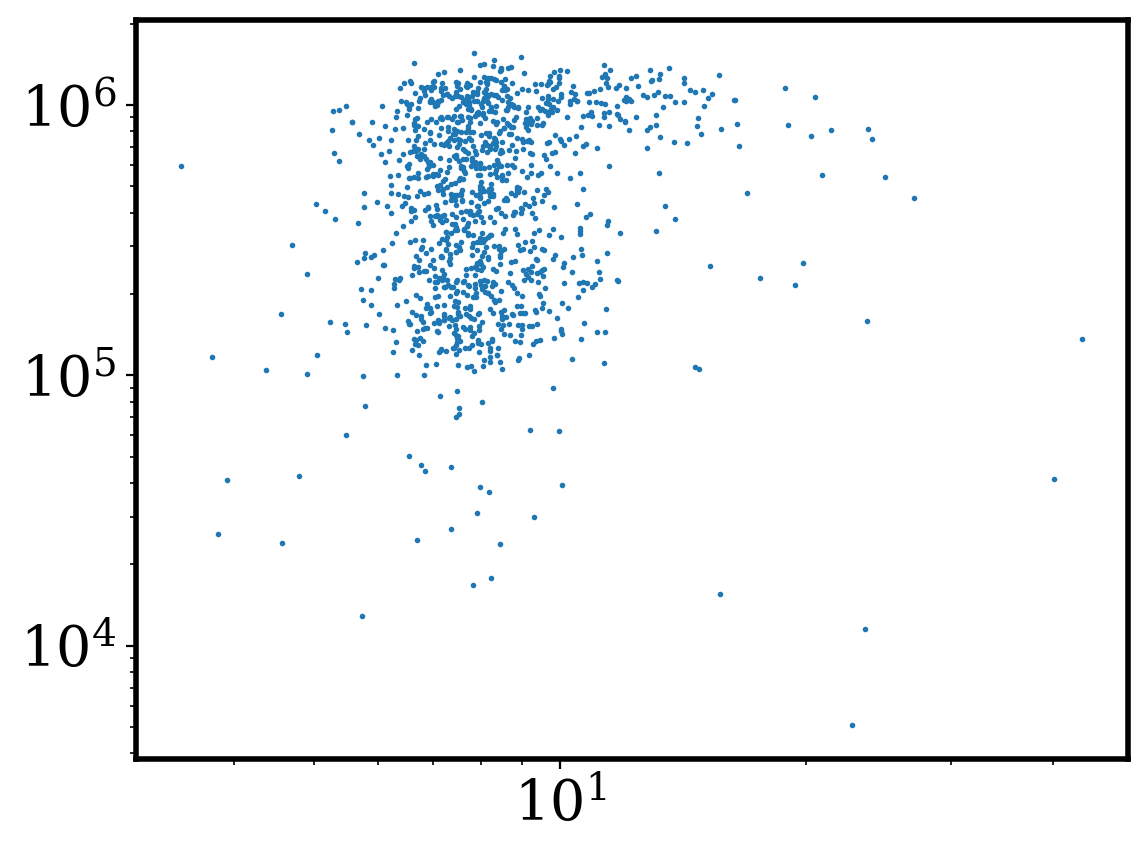

In [69]:
plt.scatter(features['snr'], features['NormExcessVar'], s=1)
plt.yscale('log')
plt.xscale('log')

In [70]:
client.close()

In [86]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.6 MB/s eta 0:00:0000:01


In [70]:
client.restart()

In [134]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37982/status,
Dashboard: http://127.0.0.1:37982/status,Workers: 6
Total threads: 6,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33472,Workers: 6
Dashboard: http://127.0.0.1:37982/status,Total threads: 6
Started: 25 minutes ago,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:43265,Total threads: 1
Dashboard: http://127.0.0.1:40283/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:42568,


In [22]:
# dipper detection pipeline
# use os for path to /astro/users/atzanida/Desktop/research/projects/LINCC-dippers-demo/scripts so that we can import the py files
import os
import sys

from evaluate import evaluate_updated, evaluate_only_dips
from dipeval import has_initial_dips
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
_sources.sources.head(1).array[0]

,ra,dec,mjd,mag,magerr,band,catflags
0,83.397352,21.929828,58487.26732,17.662407,0.027032,r,0
1,83.397352,21.929828,59195.35484,17.623491,0.026418,r,-32768
2,83.397352,21.929828,59195.35390,17.619164,0.026351,r,-32768
3,83.397352,21.929828,59194.34426,17.662437,0.027033,r,0
4,83.397352,21.929828,59155.43684,17.683270,0.027371,r,0
...,...,...,...,...,...,...,...
714,83.397352,21.929828,58363.43539,17.628944,0.026503,r,0
715,83.397352,21.929828,59107.41417,18.517921,0.046590,g,-32768
716,83.397352,21.929828,58366.49158,17.659176,0.026981,r,0
717,83.397352,21.929828,58216.13507,17.678875,0.027299,r,0


In [23]:
# Select only good photometry from Zubercal
nested_ddf_update = _sources.query("sources.catflags == 0")

# feature evaluation 
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma', # in deviation
    'Ndips',
    'rate',
    'chi2dof',
    'skew', 
    'kurtosis',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',    
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'lc_score']

q3 = nested_ddf_update.reduce(evaluate_updated,
                            "sources.mjd", 
                            "sources.mag", 
                            "sources.magerr",
                            "sources.catflags",
                            "sources.band",
                        meta={name: np.float64 for name in column_names})

In [24]:
%%time
q3_comp = q3.compute()

CPU times: user 1.69 s, sys: 733 ms, total: 2.42 s
Wall time: 21.6 s


In [21]:
q3_comp

,Nphot,biweight_scale,frac_above_2_sigma,Ndips,rate,chi2dof,skew,kurtosis,stetson_i,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,lc_score
_healpix_29,,,,,,,,,,,,,,,,,,,
1701905443136983893,256,0.024765,0.015625,0.0,0.000000,1.000795,-0.175613,1.297309,34.045975,25.138865,0.768667,0.532182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701906757799702444,34,0.016798,0.000000,0.0,0.000000,1.042333,-0.407021,-0.131106,20.063429,14.087823,0.808171,1.122502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701906781325582978,256,0.025156,0.015625,0.0,0.000000,1.003703,-0.859306,2.681783,35.957390,21.887268,0.709246,0.448655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701906791136898451,255,0.034887,0.011765,0.0,0.000000,1.007068,-0.349175,2.582383,20.253639,15.582247,0.731227,0.362433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701906796995366033,256,0.031043,0.011719,0.0,0.000000,1.006178,-0.967380,3.389062,-5.004447,-6.535864,0.701321,0.315901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702028647242234964,330,0.034373,0.009091,0.0,0.000000,1.001512,-0.717634,2.729918,-28.691429,-1.112947,0.739753,0.411556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1702028662895908633,342,0.021399,0.023392,1.0,0.000621,1.001570,-0.155964,2.978797,10.927050,19.542057,0.730020,0.428221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1702028683450201206,338,0.265765,0.056213,0.0,0.000000,1.169337,0.912885,-0.337986,2714.682617,325.141541,0.832267,0.824854,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
q3_comp[np.log10(q3_comp['lc_score'])>5]

,Nphot,biweight_scale,frac_above_2_sigma,Ndips,rate,chi2dof,skew,kurtosis,stetson_i,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,lc_score
_healpix_29,,,,,,,,,,,,,,,,,,,
1702010355316058236,42,0.015133,0.047619,1.0,0.360276,1.046177,4.12093,15.911709,28.624708,1.558492,0.374035,0.027647,18.730917,58482.22038,58455.32718,58504.26655,0.0,3.0,123288.439916


In [28]:
lc = _sources.loc[1702010355316058236].compute()

In [32]:
lc = lc.sources.array[0]

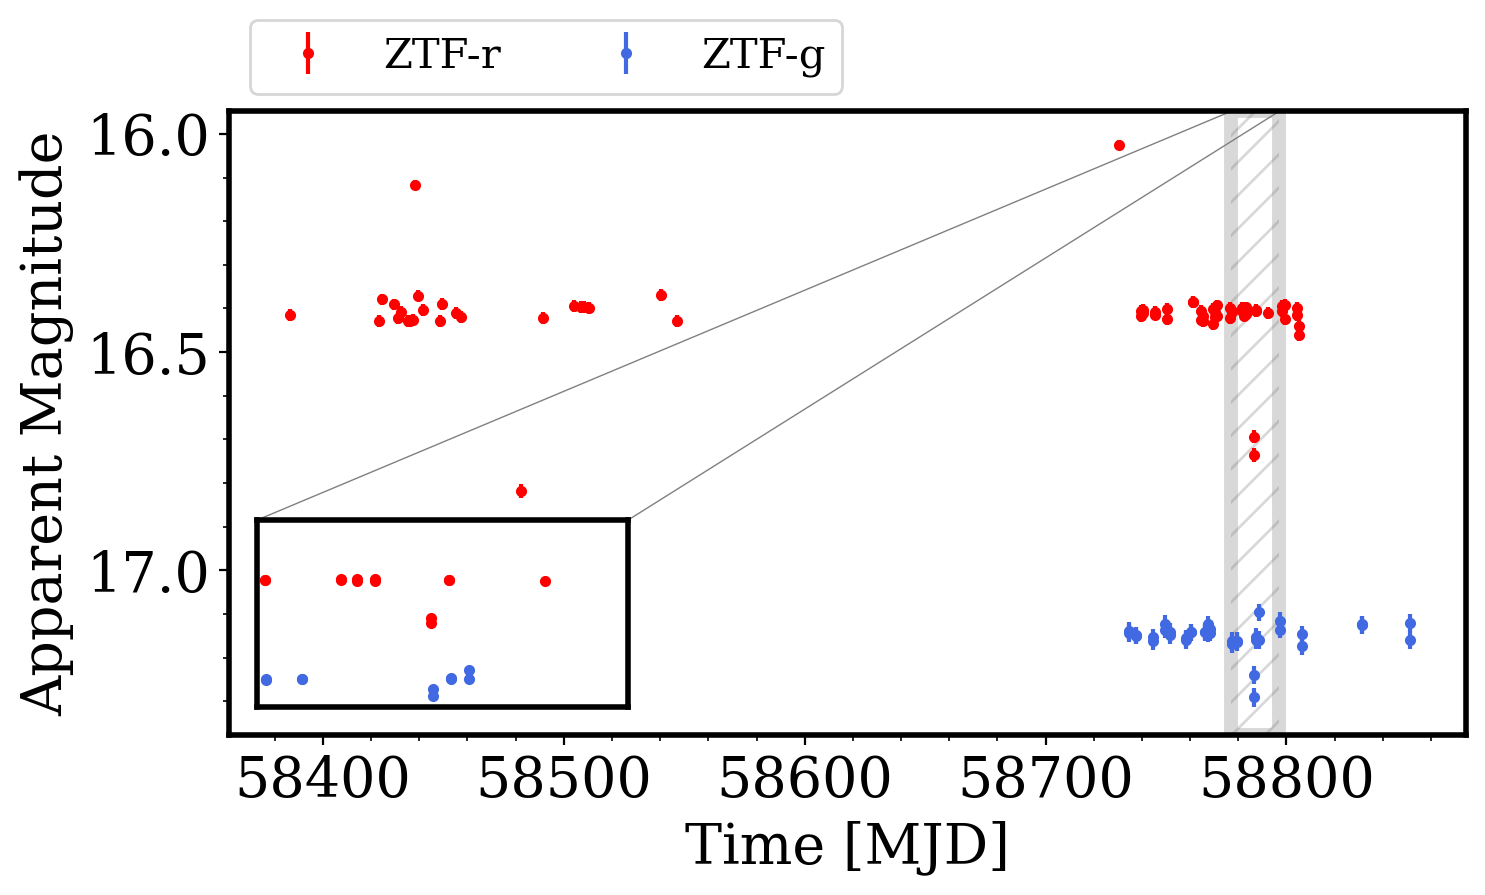

In [51]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

rband = lc[lc['band'] == 'r']
gband = lc[lc['band'] == 'g']


fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(rband['mjd'], rband['mag'], yerr=rband['magerr'], fmt='.', color='red', label='ZTF-r')
ax.errorbar(gband['mjd'], gband['mag'], yerr=gband['magerr'], fmt='.', color='RoyalBlue', label='ZTF-g')

plt.legend(loc='upper left', fontsize=15, ncols=2, bbox_to_anchor=(0,1.18))
ax.minorticks_on()
ax.set_xlabel("Time [MJD]")
ax.set_ylabel("Apparent Magnitude")
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse y-axis for magnitude

# Define the central date
central_date = 58_800 - 13

# Define the range for the hatched region (±10 days)
start_date = central_date - 10
end_date = central_date + 10

# Add the hatched region to the main plot
ax.axvspan(start_date, end_date, facecolor='none', edgecolor='gray', hatch='//', linewidth=5, alpha=0.3)

center_line = central_date
# Add an inset axis that zooms in around the vertical line
ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower left')


zoom_window = 10  # +/- 25 days around the center_line
ax_inset.errorbar(rband['mjd'], rband['mag'], yerr=rband['magerr'], fmt='.', color='red', label='ZTF-r')
ax_inset.errorbar(gband['mjd'], gband['mag'], yerr=gband['magerr'], fmt='.', color='RoyalBlue', label='ZTF-g')

ax_inset.set_xlim(center_line - zoom_window, center_line + zoom_window)
# Reverse y-axis if necessary (common in magnitude plots)
ax_inset.set_ylim(ax_inset.get_ylim()[::-1])

# Customize inset axis (optional)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

# Manually create guiding lines using ConnectionPatch
from matplotlib.patches import ConnectionPatch

# Coordinates of the zoomed-in region in data coordinates of the main axes
x1, x2 = center_line - zoom_window, center_line + zoom_window
y1, y2 = ax.get_ylim()  # y-limits of the main plot

# Since y-axis is inverted for magnitude plots, y1 > y2
# For the top edge of the zoomed-in rectangle, use y2 (since higher magnitudes are lower numbers)
# For the guiding lines, we connect the top corners of the zoomed-in area to the inset plot

# Main plot points (top left and top right corners of zoomed-in region)
main_points = [(x1, y2), (x2, y2)]  # Adjust if y-axis is not inverted

# Inset plot points (top left and top right corners in axes coordinates)
inset_points = [(0, 1), (1, 1)]  # Top left and top right in the inset axes

# Create ConnectionPatches
for mp, ip in zip(main_points, inset_points):
    con = ConnectionPatch(xyA=mp, coordsA=ax.transData,
                          xyB=ip, coordsB=ax_inset.transAxes,
                          axesA=ax, axesB=ax_inset,
                          color='0.5', lw=0.5)
    ax.add_artist(con)

plt.tight_layout()


Text(0.5, 0, 'Time [MJD]')

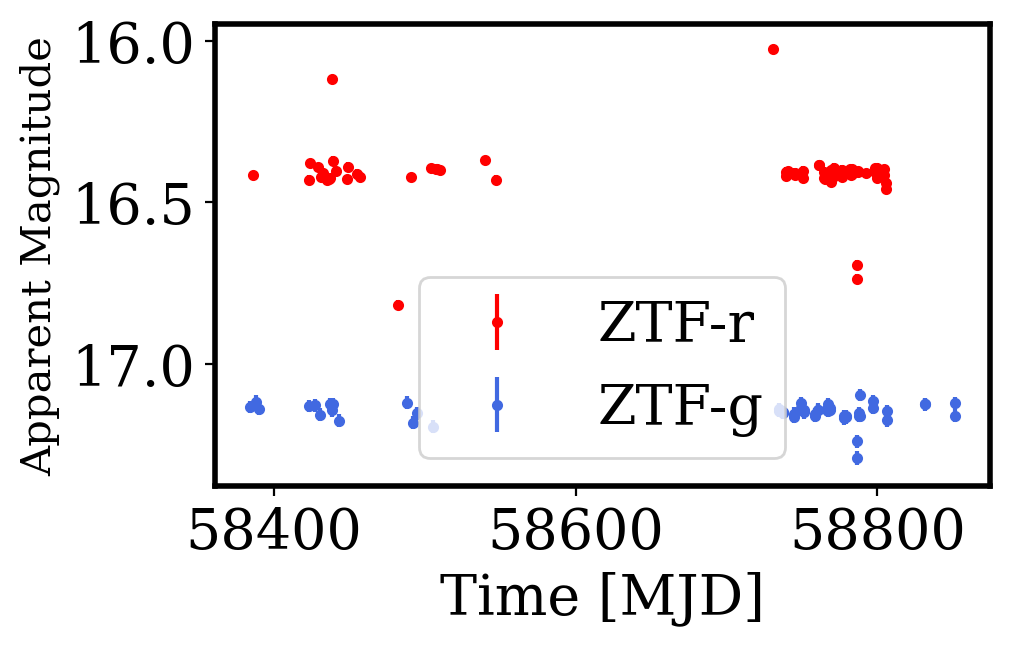